<a href="https://colab.research.google.com/github/KumudaBG/Deep-Learning-Assignment5/blob/main/partA_E2E_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import NYC data from Kaggle

In [1]:
import json
kaggle_json = {"username":"kumudabg","key":"1134be2d95490124194bf94fac598ce7"}

In [2]:
import io,os
os.makedirs('/content/.kaggle/',exist_ok=True)

In [3]:
os.makedirs('/root/.kaggle/',exist_ok=True)

In [4]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(kaggle_json, file)

In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 799kB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 63.3MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 106MB/s]
100% 1.56G/1.56G [00:09<00:00, 38.5MB/s]
100% 1.56G/1.56G [00:09<00:00, 175MB/s] 


In [7]:
! mkdir train
! unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


In [8]:
%load_ext tensorboard

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


In [10]:
df=pd.read_csv('/content/train/train.csv',nrows=20000)
df.head()
print("shape of NYC data", df.shape)


shape of NYC data (20000, 8)


In [11]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


#Data Preprocessing

In [12]:
df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format= "%Y-%m-%d %H:%M:%S UTC")
df['trip_start_month'] = df['pickup_datetime'].dt.month
df['trip_start_hour'] = df['pickup_datetime'].dt.hour
df['trip_start_day'] = df['pickup_datetime'].dt.day
df = df.rename(columns={'fare_amount': 'fare'})

In [13]:
df = df[(df['pickup_longitude'] <= -73.8)]
df = df[(df['pickup_latitude'] < 40.9)]
df = df[(df['dropoff_longitude'] <= -73.8)]
df = df[(df['dropoff_latitude'] < 40.9)]

df = df[(df['dropoff_longitude'] > -74.2)]
df = df[(df['pickup_longitude'] > -74.2)]
df = df[(df['pickup_latitude'] > 40.5)]
df = df[(df['dropoff_latitude'] > 40.5)]

In [14]:
df.nunique()

key                  19099
fare                   450
pickup_datetime      19028
pickup_longitude     16202
pickup_latitude      16852
dropoff_longitude    16421
dropoff_latitude     16951
passenger_count          7
trip_start_month        12
trip_start_hour         24
trip_start_day          31
dtype: int64

In [15]:
df.head()

,key,fare,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_start_month,trip_start_hour,trip_start_day
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,6,17,15
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,1,16,5
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,8,0,18
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,4,21
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,3,7,9


In [16]:
##Drop useless columns
df = df.drop(['key','passenger_count','pickup_datetime'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19099 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               19099 non-null  float64
 1   pickup_longitude   19099 non-null  float64
 2   pickup_latitude    19099 non-null  float64
 3   dropoff_longitude  19099 non-null  float64
 4   dropoff_latitude   19099 non-null  float64
 5   trip_start_month   19099 non-null  int64  
 6   trip_start_hour    19099 non-null  int64  
 7   trip_start_day     19099 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 1.3 MB


In [17]:
#Drop NA rows
df = df.dropna()

#Drop rows where FARE > 200( only 1 row found )
df = df.drop(df[df['fare'] > 200].index)

In [18]:


#Change datatype of cols
df['trip_start_month'] = df['trip_start_month'].astype('str')
df['trip_start_hour'] = df['trip_start_hour'].astype('str')
df['trip_start_day'] = df['trip_start_day'].astype('str')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19099 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               19099 non-null  float64
 1   pickup_longitude   19099 non-null  float64
 2   pickup_latitude    19099 non-null  float64
 3   dropoff_longitude  19099 non-null  float64
 4   dropoff_latitude   19099 non-null  float64
 5   trip_start_month   19099 non-null  object 
 6   trip_start_hour    19099 non-null  object 
 7   trip_start_day     19099 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.9+ MB


In [19]:
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

16214
2885


#Data Exploration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


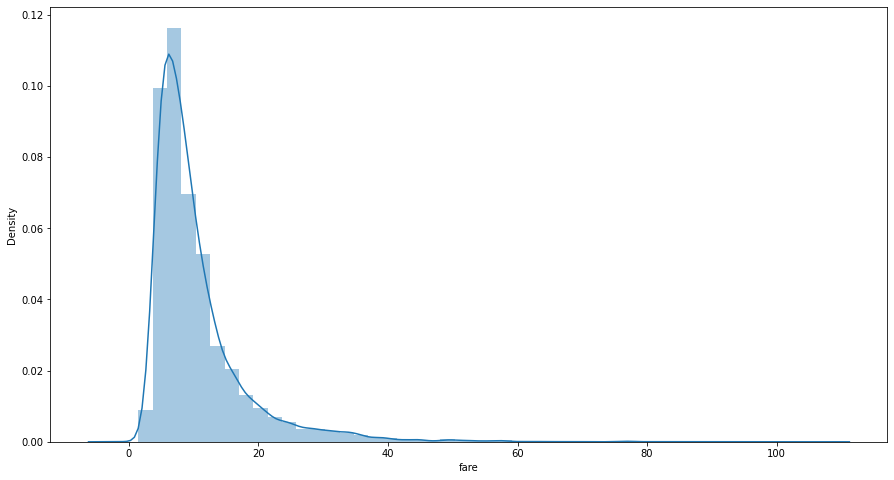

In [20]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare'])

In [21]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare']), radius = 10))
m.fit_bounds([sw, ne])
m

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

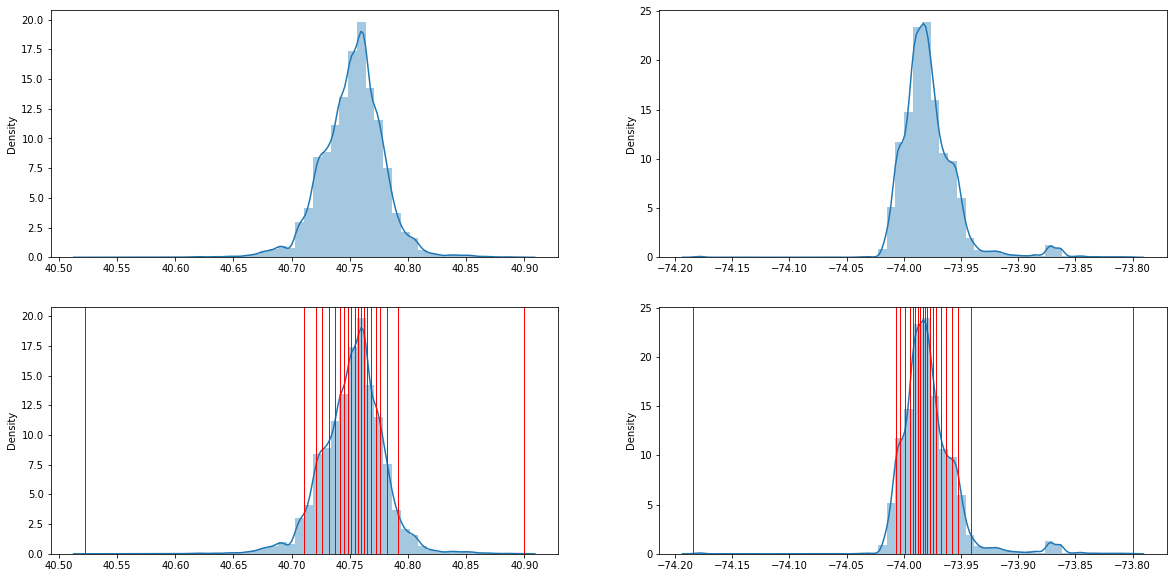

In [22]:
##Quantile Bucketization of latitude and longitude
# bins_lat = np.linspace(np.min([np.min(df['dropoff_latitude']),np.min(df['pickup_latitude'])]),
#             np.max([np.max(df['dropoff_latitude']),np.max(df['pickup_latitude'])]),
#             20)
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]

# bins_lon = np.linspace(np.min([np.min(df['dropoff_longitude']),np.min(df['pickup_longitude'])]),
#             np.max([np.max(df['dropoff_longitude']),np.max(df['pickup_longitude'])]),
#             20)
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

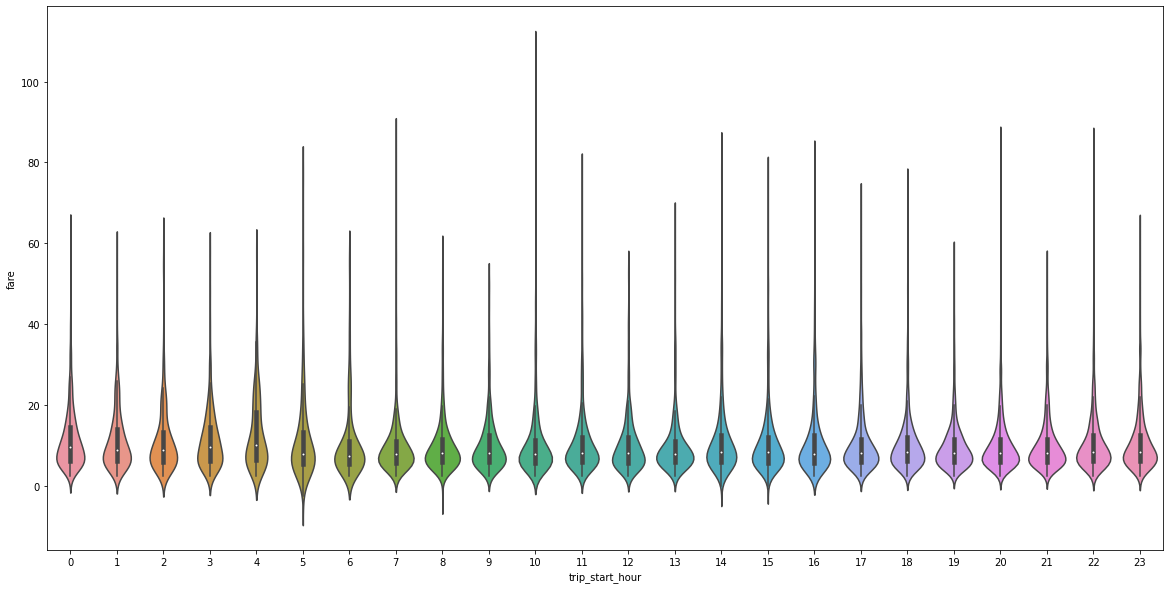

In [23]:

plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

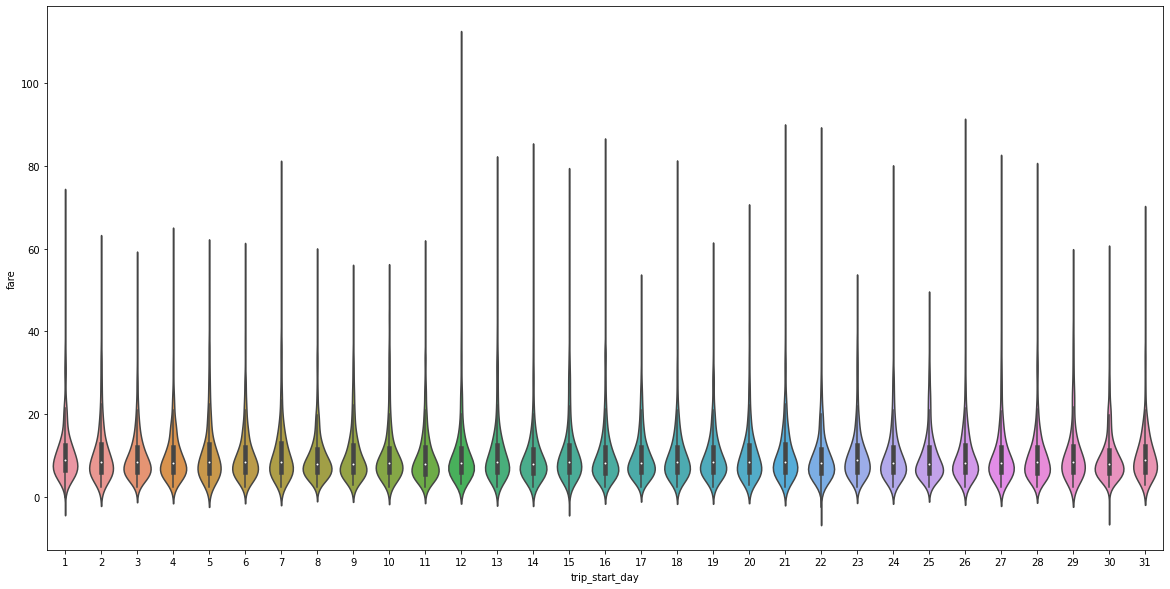

In [24]:

plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare'])

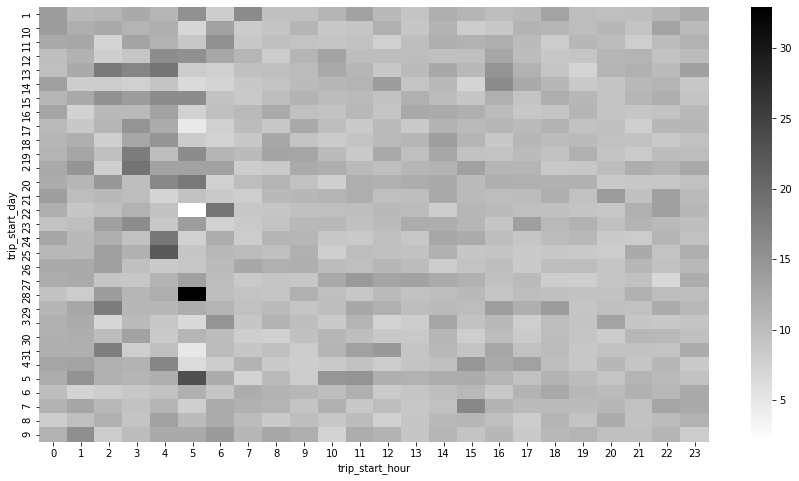

In [25]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

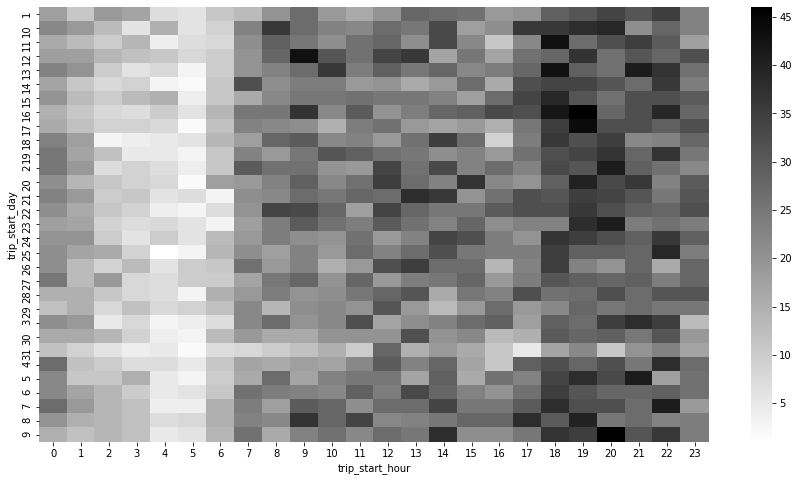

In [26]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

#Feature engineering exploration

In [27]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head()

,fare,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_start_month,trip_start_hour,trip_start_day,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,6,17,15,0.943584
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5,7.969567
2,5.7,-73.982738,40.761270,-73.991242,40.750562,8,0,18,1.367404
3,7.7,-73.987130,40.733143,-73.991567,40.758092,4,4,21,2.534047
4,5.3,-73.968095,40.768008,-73.956655,40.783762,3,7,9,1.946952


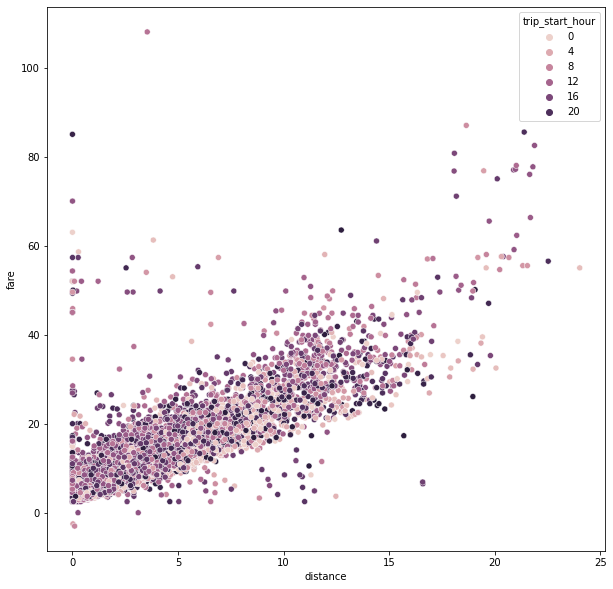

In [28]:
##Fair Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=traindf['distance'], y=traindf['fare'], hue=traindf['trip_start_hour'].astype(int))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


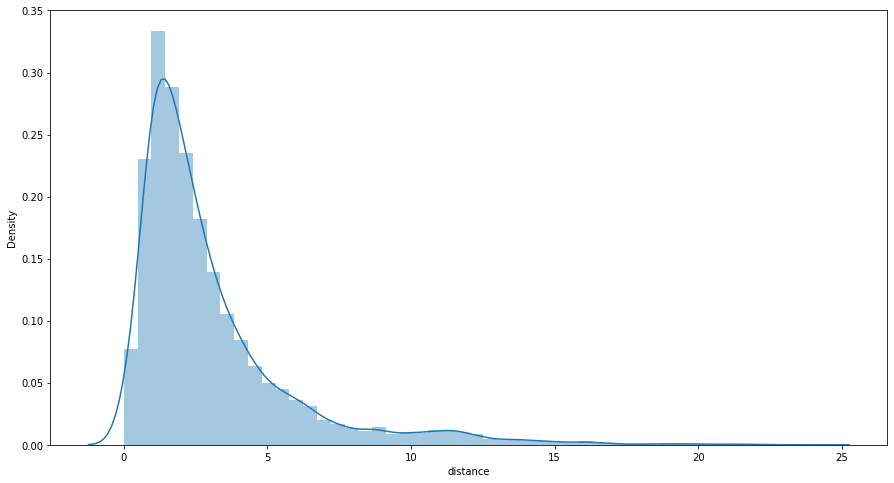

In [29]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['distance'])

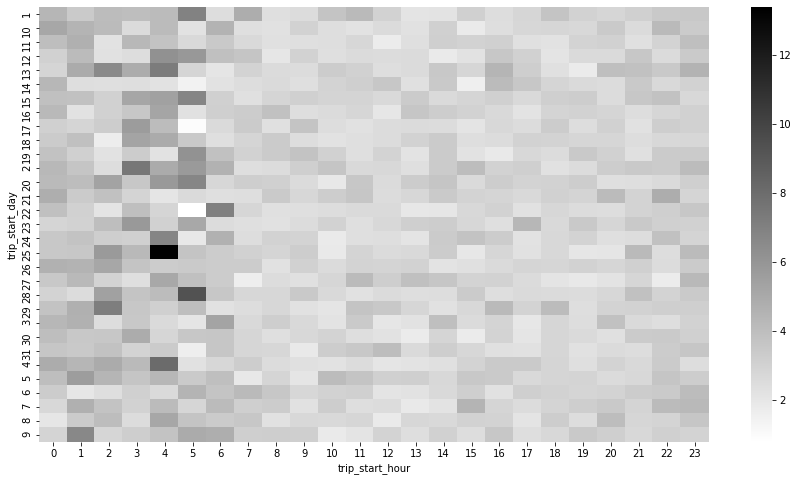

In [30]:
##Average trip distance( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['distance'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [31]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

16214
2885


,fare,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_start_month,trip_start_hour,trip_start_day
0,4.5,-73.844311,40.721319,-73.841610,40.712278,6,17,15
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5
2,5.7,-73.982738,40.761270,-73.991242,40.750562,8,0,18
3,7.7,-73.987130,40.733143,-73.991567,40.758092,4,4,21
4,5.3,-73.968095,40.768008,-73.956655,40.783762,3,7,9


#Data - Ingestion Pipeline

In [32]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)

In [33]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [[0.0],[0.0],[0.0],[0.0],[0.0],['1'], ['1'],['1']]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [34]:
eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.9828  , -73.98846 , -73.98988 , -73.99878 , -73.98204 ,
       -73.97512 , -73.976585, -73.97314 , -73.95273 , -73.80468 ],
      dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40.768635, 40.75843 , 40.74267 , 40.7341  , 40.756367, 40.79035 ,
       40.759132, 40.755566, 40.7909  , 40.680893], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.968895, -73.98382 , -73.988815, -73.98244 , -73.98205 ,
       -73.94545 , -73.92374 , -73.98833 , -74.006966, -73.99025 ],
      dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40.761883, 40.73015 , 40.75752 , 40.727913, 40.756325, 40.840343,
       40.6942  , 40.725925, 40.736374, 40.730408], dtype=float32)>), ('trip_start_month', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'5', b'5', b'4', b'4', b'7', b'4', 

<DatasetV1Adapter shapes: (OrderedDict([(pickup_longitude, (None,)), (pickup_latitude, (None,)), (dropoff_longitude, (None,)), (dropoff_latitude, (None,)), (trip_start_month, (None,)), (trip_start_hour, (None,)), (trip_start_day, (None,)), (distance, (None,))]), (None,)), types: (OrderedDict([(pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (trip_start_month, tf.string), (trip_start_hour, tf.string), (trip_start_day, tf.string), (distance, tf.float32)]), tf.float32)>

In [35]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               16214 non-null  float64
 1   pickup_longitude   16214 non-null  float64
 2   pickup_latitude    16214 non-null  float64
 3   dropoff_longitude  16214 non-null  float64
 4   dropoff_latitude   16214 non-null  float64
 5   trip_start_month   16214 non-null  object 
 6   trip_start_hour    16214 non-null  object 
 7   trip_start_day     16214 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.1+ MB


In [36]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>}}

#Model - Training pipeline

In [37]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [38]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
______________________________________________________________________________________________

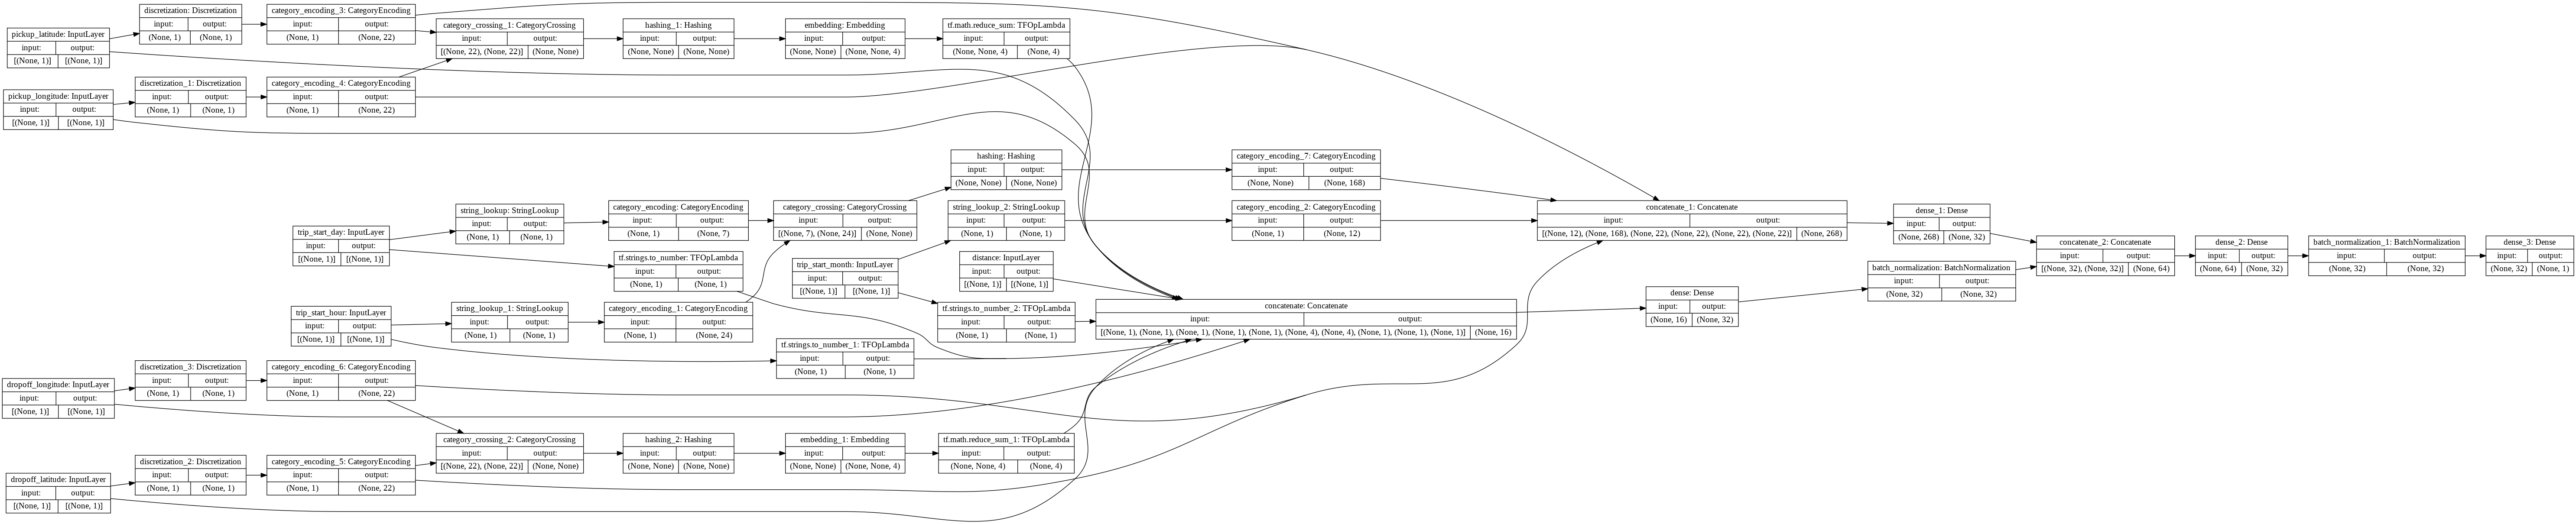

In [39]:
#Create dataset input functions
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [40]:
# !rm -rf "./logs"
# %tensorboard --logdir "./logs"

keras_train_and_evaluate(m_, train_dataset, validation_dataset, 50)

Epoch 1/50
100/100 [==============================] - 26s 211ms/step - loss: 141.4162 - rmse: 11.8848 - val_loss: 168.2987 - val_rmse: 12.9727
Epoch 2/50
100/100 [==============================] - 20s 202ms/step - loss: 107.3785 - rmse: 10.3565 - val_loss: 168.1594 - val_rmse: 12.9675
Epoch 3/50
100/100 [==============================] - 20s 201ms/step - loss: 88.4884 - rmse: 9.4046 - val_loss: 164.5529 - val_rmse: 12.8277
Epoch 4/50
100/100 [==============================] - 20s 203ms/step - loss: 61.3641 - rmse: 7.8317 - val_loss: 143.4658 - val_rmse: 11.9777
Epoch 5/50
100/100 [==============================] - 20s 202ms/step - loss: 49.6884 - rmse: 7.0475 - val_loss: 94.6337 - val_rmse: 9.7279
Epoch 6/50
100/100 [==============================] - 20s 202ms/step - loss: 37.5169 - rmse: 6.1238 - val_loss: 45.1741 - val_rmse: 6.7211
Epoch 7/50
100/100 [==============================] - 20s 204ms/step - loss: 33.5604 - rmse: 5.7887 - val_loss: 105.3416 - val_rmse: 10.2635
Epoch 8/50
10

In [41]:
# ## Prediction directly using model's instance
# ## BUT HERE ALL FEATURES HAVE TO BE PASSED, EVEN THE Calculated ones
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                         'distance':[[0.04196861]]})

m_.predict(data)

array([[0.]], dtype=float32)

#Serving: Export model

In [42]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 


INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [43]:
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.index
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/saved_model.pb
/content/exported_model/1/assets/


In [44]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['pickup_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_pickup_latitude:0
    inputs['pickup_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
 

In [45]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>}

In [46]:
!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  31645      0 --:--:-- --:--:-- --:--:-- 31308
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 ht

In [47]:

###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 0 in a separate thread.


In [48]:
!tail server.log

2021-04-23 18:46:45.279888: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /content/exported_model/1
2021-04-23 18:46:45.329131: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 233976 microseconds.
2021-04-23 18:46:45.337437: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/exported_model/1/assets.extra/tf_serving_warmup_requests
2021-04-23 18:46:45.337577: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: model version: 1}
2021-04-23 18:46:45.339227: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-04-23 18:46:45.339289: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2021-04-23 18:46:45.339816: I tensorflow_serving/model_servers/server.cc:393] Running gRPC

In [49]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': [41.920452],
                         'dropoff_longitude': [-87.679955],
                         'pickup_latitude': [41.952823],
                         'pickup_longitude': [-87.653244],
                         'trip_start_day': ["1"],
                         'trip_start_hour': ["5"],
                         'trip_start_month': ["6"]}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text

payload:  {"instances": [{"dropoff_latitude": [41.920452], "dropoff_longitude": [-87.679955], "pickup_latitude": [41.952823], "pickup_longitude": [-87.653244], "trip_start_day": ["1"], "trip_start_hour": ["5"], "trip_start_month": ["6"]}]}


'{\n    "error": "Shape must be at most rank 2 but is rank 3\\n\\t [[{{node model/category_encoding/bincount/DenseBincount}}]]"\n}'